In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

## 2006 MCMC

In [2]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_06(log_A,log_f_b,alpha_H,log_poisson):
    alpha_L = 1.0
    
    perdata06 = pd.read_csv("perlist06_s.csv")
    f = perdata06['f']
    per = perdata06['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
     
    
    length = len(perdata06)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [3]:
m06=Minuit(twi_minus_loglikelihood_06,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,log_poisson=0.0,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_log_poisson=0.1,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_log_poisson=(0,3),
         errordef=1)

m06.migrad()

pprint(m06.fval)

FCN = -1236.9677578079807 
 TOTAL NCALL = 159 
 NCALLS = 159 
 
 
 EDM = 1.989476009735364e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-2.29215,0.158339,,,-3,-1,No
1,log_f_b,-3.86704,0.136486,,,-5,-2,No
2,alpha_H,3.3068,0.348349,,,1,5,No
3,poisson,0.168015,0.00554297,,,0,2,No


-1236.9677578079807


In [4]:
# 均匀先验

def lnprior_06(theta):
    log_A,log_f_b,alpha_H,log_poisson = theta
    alpha_L = 1.0
    if -3 < log_A < -2 and -5 < log_f_b < -3 and 2.0 < alpha_H < 6.0 and 0.0 < log_poisson < 5.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_06(theta):
    log_A,log_f_b,alpha_H,log_poisson = theta
    lp = lnprior_06(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_06(log_A,log_f_b,alpha_H,log_poisson))

In [5]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m06.values[0],m06.values[1],m06.values[2],m06.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_06)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1645.6 seconds


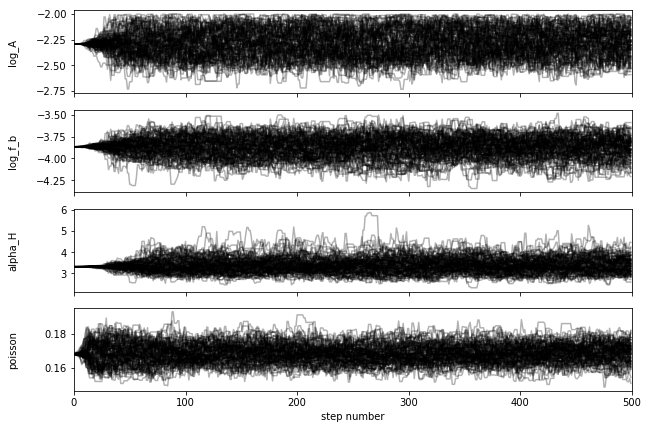

In [6]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","log poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [7]:
print ("Parameters (2006)")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","log poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2006)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

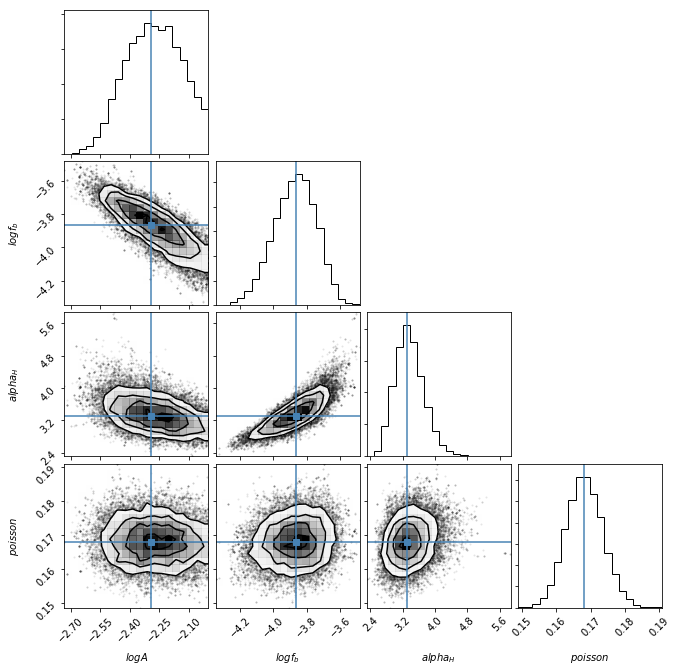

In [8]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$log poisson$"],
                      truths=[m06.values[0], m06.values[1], m06.values[2], m06.values[3]])

## 2009(1) MCMC

In [9]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_091(log_A,log_f_b,alpha_H,log_poisson):
    alpha_L = 1.0
    
    perdata091 = pd.read_csv("perlist091_s.csv")
    f = perdata091['f']
    per = perdata091['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
     
    
    length = len(perdata091)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [10]:
m091=Minuit(twi_minus_loglikelihood_091,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,log_poisson=0.0,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_log_poisson=0.1,
         limit_log_A=(-3,-1), limit_log_f_b=(-6,-2),limit_alpha_H=(1.0,5.0),limit_log_poisson=(0,3),
         errordef=1)

m091.migrad()

pprint(m091.fval)

FCN = 3227.1304151883483 
 TOTAL NCALL = 284 
 NCALLS = 284 
 
 
 EDM = 1.974205590084926e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.14163,0.383623,,,-3,-1,No
1,log_f_b,-4.65901,0.406627,,,-6,-2,No
2,alpha_H,2.57255,0.273953,,,1,5,No
3,poisson,1.62531,0.0551025,,,0,15,No


3227.1304151883483


In [11]:
# 均匀先验

def lnprior_091(theta):
    log_A,log_f_b,alpha_H,log_poisson = theta
    alpha_L = 1.0
    if -10 < log_A < 10 and -25 < log_f_b < -1 and 1.0 < alpha_H < 5.0 and 0.0 < log_poisson < 5.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_091(theta):
    log_A,log_f_b,alpha_H,log_poisson = theta
    lp = lnprior_091(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_091(log_A,log_f_b,alpha_H,log_poisson))

In [12]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m091.values[0],m091.values[1],m091.values[2],m091.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_091)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[#                             ]

F:\Anaconda\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
F:\Anaconda\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


[##############################]
Serial took 0.6 seconds


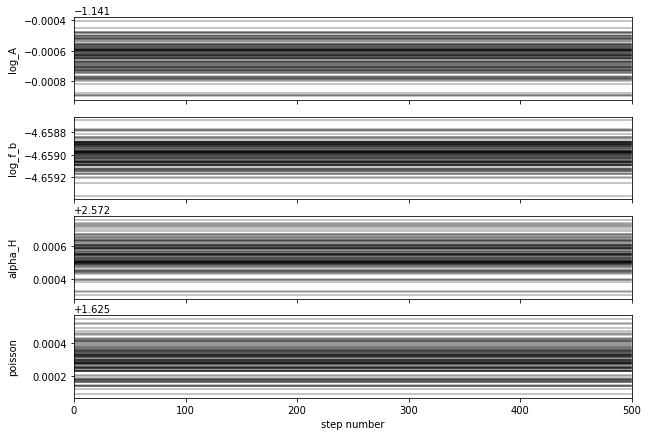

In [13]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","log poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [14]:
print ("Parameters (2009(1))")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","log poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2009(1))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

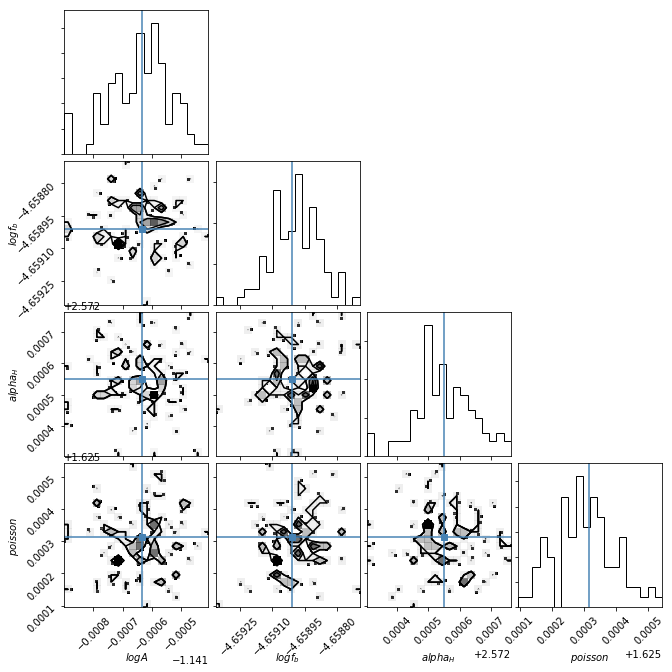

In [15]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$log poisson$"],
                      truths=[m091.values[0], m091.values[1], m091.values[2], m091.values[3]])

## 2009(2) MCMC

In [16]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_092(log_A,log_f_b,alpha_H,log_poisson):
    alpha_L = 1.0
    
    perdata092 = pd.read_csv("perlist092_s.csv")
    f = perdata092['f']
    per = perdata092['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+(10**log_poisson))
     
    
    length = len(perdata092)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [17]:
m092=Minuit(twi_minus_loglikelihood_092,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,log_poisson=0.0,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_log_poisson=0.1,
         limit_log_A=(-3,0), limit_log_f_b=(-8,-2),limit_alpha_H=(1.0,5.0),limit_log_poisson=(0,3),
         errordef=1)

m092.migrad()

pprint(m092.fval)

FCN = 2866.814680072467 
 TOTAL NCALL = 485 
 NCALLS = 485 
 
 
 EDM = 1.2374386978136725e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.14123,0.540303,,,-3,0,No
1,log_f_b,-4.59535,0.466385,,,-8,-2,No
2,alpha_H,2.82848,0.410763,,,1,5,No
3,poisson,1.96454,0.0726113,,,0,15,No


2866.814680072467


In [18]:
# 均匀先验

def lnprior_092(theta):
    log_A,log_f_b,alpha_H,log_poisson = theta
    alpha_L = 1.0
    if -10 < log_A < 20 and -35 < log_f_b < -2 and 1.0 < alpha_H < 4.0 and 0.0 < log_poisson < 5.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_092(theta):
    log_A,log_f_b,alpha_H,log_poisson = theta
    lp = lnprior_092(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_092(log_A,log_f_b,alpha_H,log_poisson))

In [19]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m092.values[0],m092.values[1],m092.values[2],m092.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_092)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[###########                   ]

F:\Anaconda\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
F:\Anaconda\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


[##############################]
Serial took 0.4 seconds


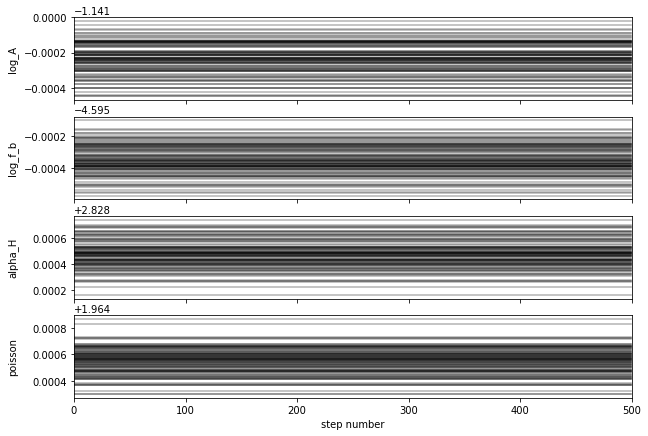

In [20]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","log poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [21]:
print ("Parameters (2009(2))")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","log poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2009(2))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

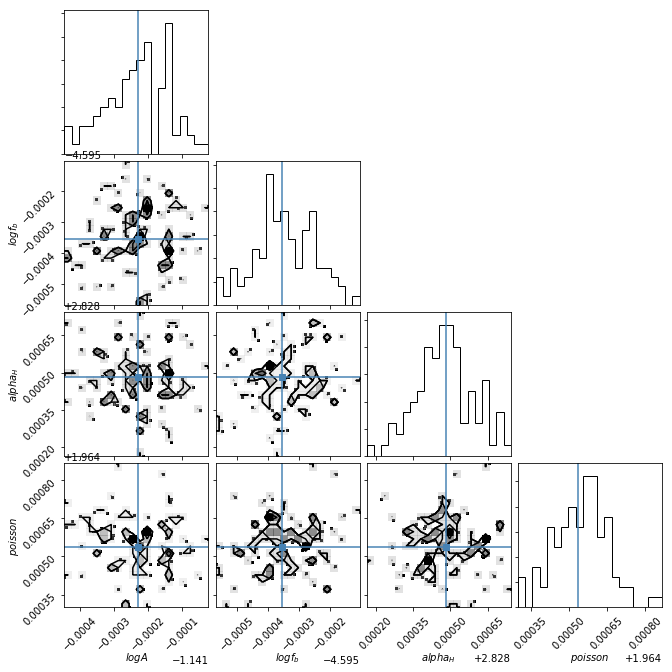

In [22]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$log poisson$"],
                      truths=[m092.values[0], m092.values[1], m092.values[2], m092.values[3]])